# Census Income Project

Problem Statement:


This data was extracted from the 1994 Census bureau database by Ronny Kohavi and Barry Becker (Data Mining and Visualization, Silicon Graphics). A set of reasonably clean records was extracted using the following conditions: ((AAGE>16) && (AGI>100) && (AFNLWGT>1) && (HRSWK>0)). The prediction task is to determine whether a person makes over $50K a year.
Description of fnlwgt (final weight)

The weights on the Current Population Survey (CPS) files are controlled to independent estimates of the civilian non-institutional population of the US. These are prepared monthly for us by Population Division here at the Census Bureau. We use 3 sets of controls. These are:

    A single cell estimate of the population 16+ for each state.

    Controls for Hispanic Origin by age and sex.

    Controls by Race, age and sex.

We use all three sets of controls in our weighting program and "rake" through them 6 times so that by the end we come back to all the controls we used. The term estimate refers to population totals derived from CPS by creating "weighted tallies" of any specified socio-economic characteristics of the population. People with similar demographic characteristics should have similar weights. There is one important caveat to remember about this statement. That is that since the CPS sample is actually a collection of 51 state samples, each with its own probability of selection, the statement only applies within state.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,precision_recall_curve,roc_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import cross_val_score
import joblib
import warnings
warnings.filterwarnings('ignore')

# Loading Data

In [2]:
df=pd.read_csv(r'C:\Users\SYS1\Downloads\census_income.csv')

In [3]:
df.head()

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


In [4]:
df.describe()

,Age,Fnlwgt,Education_num,Capital_gain,Capital_loss,Hours_per_week
count,32560.000000,3.256000e+04,32560.000000,32560.000000,32560.000000,32560.000000
mean,38.581634,1.897818e+05,10.080590,1077.615172,87.306511,40.437469
std,13.640642,1.055498e+05,2.572709,7385.402999,402.966116,12.347618
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178315e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783630e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370545e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [5]:
df.dtypes

Age                int64
Workclass         object
Fnlwgt             int64
Education         object
Education_num      int64
Marital_status    object
Occupation        object
Relationship      object
Race              object
Sex               object
Capital_gain       int64
Capital_loss       int64
Hours_per_week     int64
Native_country    object
Income            object
dtype: object

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32560 entries, 0 to 32559
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32560 non-null  int64 
 1   Workclass       32560 non-null  object
 2   Fnlwgt          32560 non-null  int64 
 3   Education       32560 non-null  object
 4   Education_num   32560 non-null  int64 
 5   Marital_status  32560 non-null  object
 6   Occupation      32560 non-null  object
 7   Relationship    32560 non-null  object
 8   Race            32560 non-null  object
 9   Sex             32560 non-null  object
 10  Capital_gain    32560 non-null  int64 
 11  Capital_loss    32560 non-null  int64 
 12  Hours_per_week  32560 non-null  int64 
 13  Native_country  32560 non-null  object
 14  Income          32560 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [7]:
#Let remove the unwanted data from stored data
df=df[df['Native_country']!='?']
df

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32555,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32556,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32557,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32558,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


From the above we got the below points



1 The mean is more than median 50% percentile in all columns.

2 There is a large difference in 75% percentile .

3 The 1 and 2 observation suggest that there are extreme outliers present in these three columns.


In [8]:
df.Native_country.unique()

array([' United-States', ' Cuba', ' Jamaica', ' India', ' ?', ' Mexico',
       ' South', ' Puerto-Rico', ' Honduras', ' England', ' Canada',
       ' Germany', ' Iran', ' Philippines', ' Italy', ' Poland',
       ' Columbia', ' Cambodia', ' Thailand', ' Ecuador', ' Laos',
       ' Taiwan', ' Haiti', ' Portugal', ' Dominican-Republic',
       ' El-Salvador', ' France', ' Guatemala', ' China', ' Japan',
       ' Yugoslavia', ' Peru', ' Outlying-US(Guam-USVI-etc)', ' Scotland',
       ' Trinadad&Tobago', ' Greece', ' Nicaragua', ' Vietnam', ' Hong',
       ' Ireland', ' Hungary', ' Holand-Netherlands'], dtype=object)

Target/dependent variables is discrete and categorial in nature

In [9]:
df.Native_country.value_counts()

 United-States                 29169
 Mexico                          643
 ?                               583
 Philippines                     198
 Germany                         137
 Canada                          121
 Puerto-Rico                     114
 El-Salvador                     106
 India                           100
 Cuba                             95
 England                          90
 Jamaica                          81
 South                            80
 China                            75
 Italy                            73
 Dominican-Republic               70
 Vietnam                          67
 Guatemala                        64
 Japan                            62
 Poland                           60
 Columbia                         59
 Taiwan                           51
 Haiti                            44
 Iran                             43
 Portugal                         37
 Nicaragua                        34
 Peru                             31
 

Here Native_country contains some categorical values

# Data Visualization

<AxesSubplot:xlabel='Workclass', ylabel='count'>

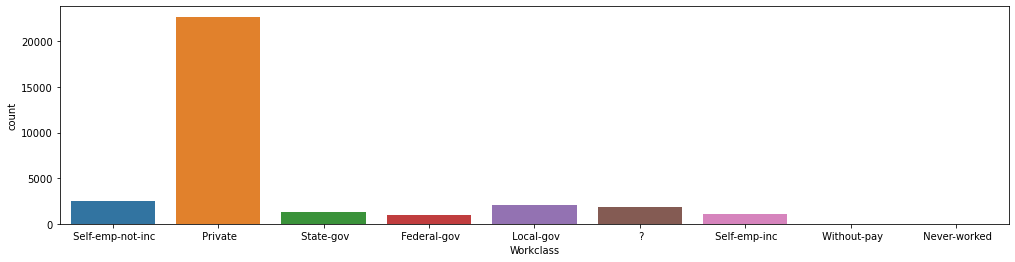

In [10]:
plt.figure(figsize=(17,4))
sns.countplot(df['Workclass'])

<AxesSubplot:xlabel='Education_num', ylabel='count'>

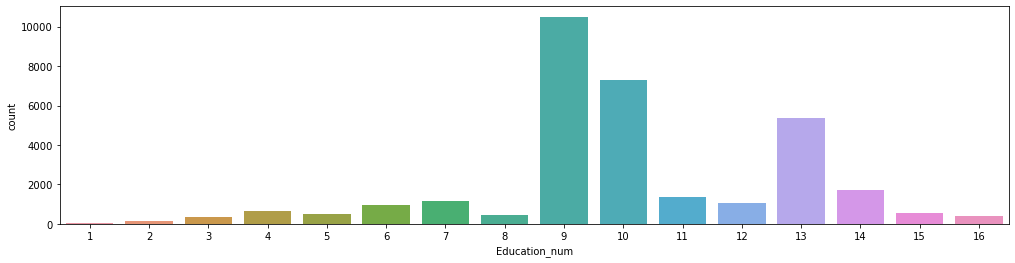

In [11]:
plt.figure(figsize=(17,4))
sns.countplot(df['Education_num'])

<AxesSubplot:xlabel='Occupation', ylabel='count'>

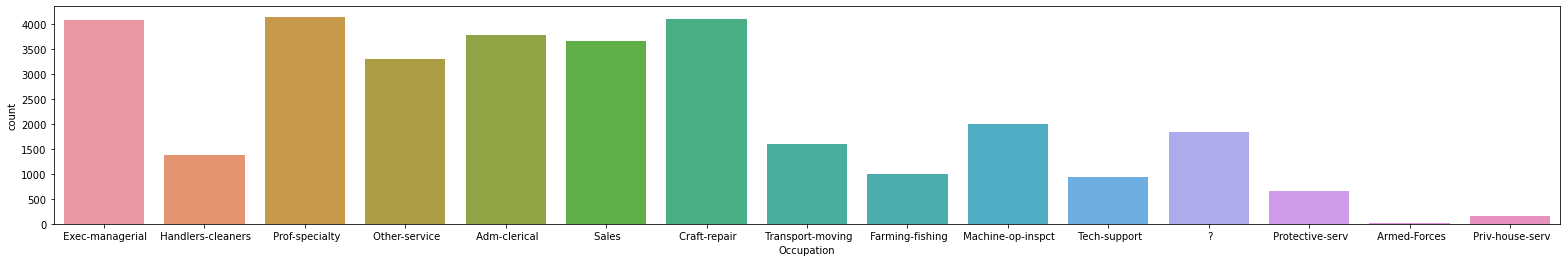

In [12]:
plt.figure(figsize=(27,4))
sns.countplot(df['Occupation'])

<AxesSubplot:xlabel='Marital_status', ylabel='count'>

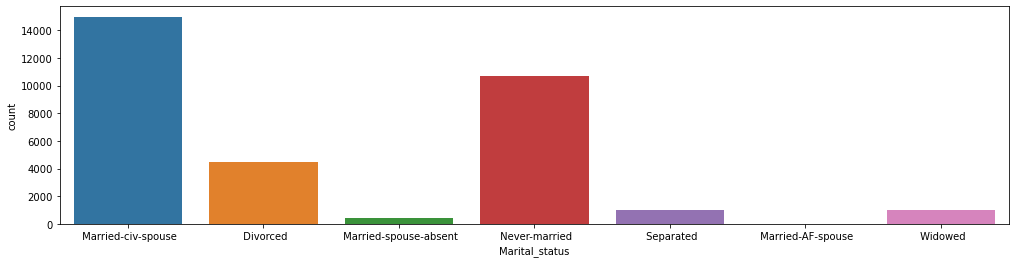

In [13]:
plt.figure(figsize=(17,4))
sns.countplot(df['Marital_status'])

<AxesSubplot:xlabel='Native_country', ylabel='count'>

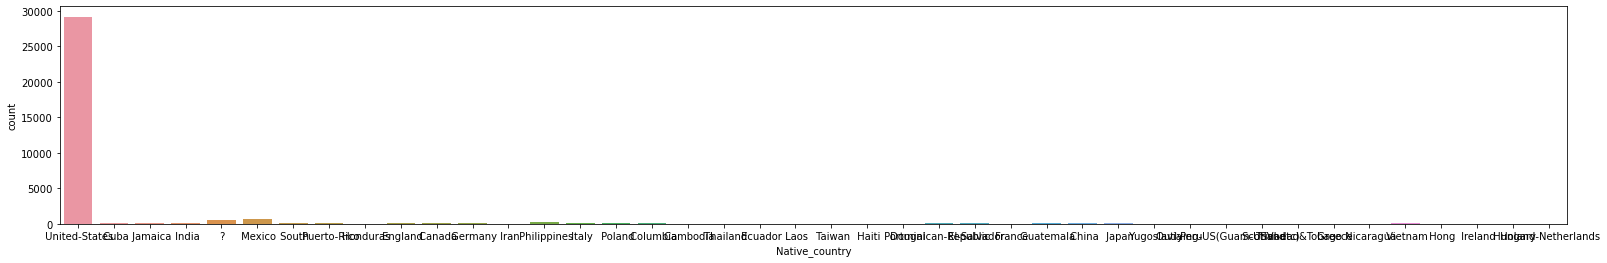

In [14]:
plt.figure(figsize=(27,4))
sns.countplot(df['Native_country'])

From all the above data is not equally distributed

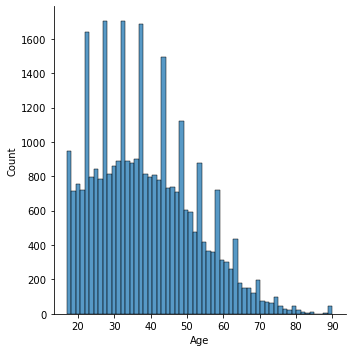

In [16]:
sns.displot(df['Age'])

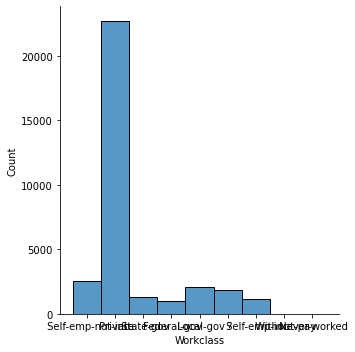

In [17]:
sns.displot(df['Workclass'])

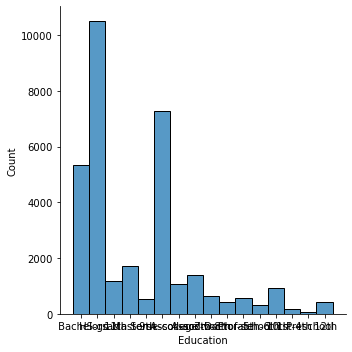

In [18]:
sns.displot(df['Education'])

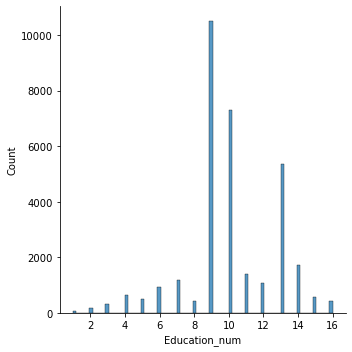

In [19]:
sns.displot(df['Education_num'])

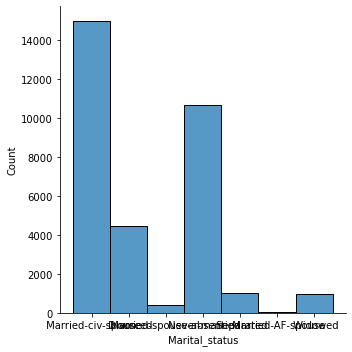

In [20]:
sns.displot(df['Marital_status'])

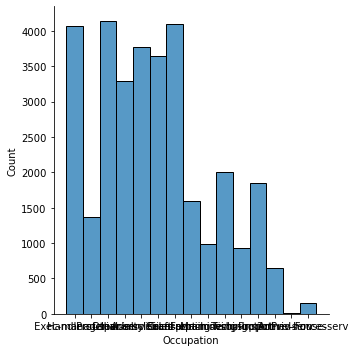

In [21]:
sns.displot(df['Occupation'])

From the above all data is not equally distributed

<AxesSubplot:>

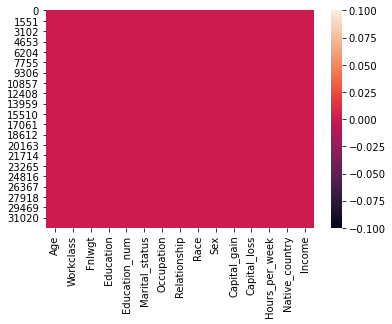

In [22]:
sns.heatmap(df.isnull())

Here heatmap contains all the nullvalues of the dataset.

In [23]:
dfcor=df.corr()
dfcor

,Age,Fnlwgt,Education_num,Capital_gain,Capital_loss,Hours_per_week
Age,1.000000,-0.076646,0.036527,0.077674,0.057775,0.068756
Fnlwgt,-0.076646,1.000000,-0.043159,0.000437,-0.010259,-0.018770
Education_num,0.036527,-0.043159,1.000000,0.122627,0.079932,0.148127
Capital_gain,0.077674,0.000437,0.122627,1.000000,-0.031614,0.078409
Capital_loss,0.057775,-0.010259,0.079932,-0.031614,1.000000,0.054256
Hours_per_week,0.068756,-0.018770,0.148127,0.078409,0.054256,1.000000


<AxesSubplot:>

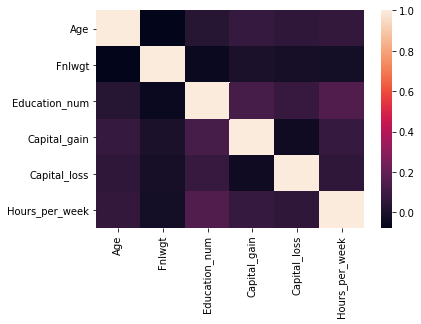

In [24]:
sns.heatmap(dfcor)

Here heatmap contains all the nullvalues of the dataset.
Light shades are higly corrolated

<AxesSubplot:>

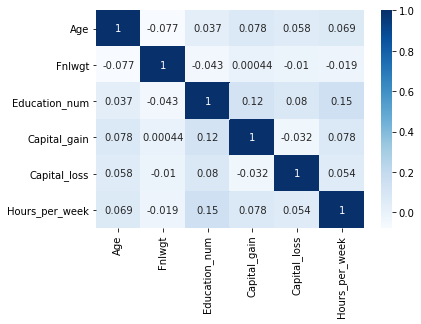

In [26]:
plt.figure(figsize=(6,4))
sns.heatmap(dfcor,cmap='Blues',annot=True)

Dark shades are higly correlated

<AxesSubplot:>

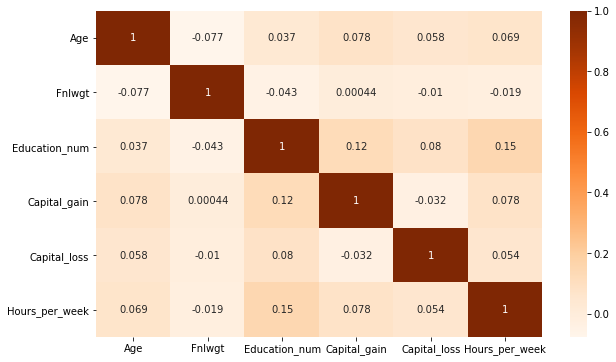

In [27]:
plt.figure(figsize=(10,6))
sns.heatmap(dfcor,cmap='Oranges',annot=True)



Light shades are higly correlated

Hour_per_week is higly correlated with capital_loss

capital_loss is highly negatively correlated with capital_gain

capital_gain is higly positively correlated with age

age is negatively correlated with house_per_week


# Plotting Outliers

In [28]:
df.columns

Index(['Age', 'Workclass', 'Fnlwgt', 'Education', 'Education_num',
       'Marital_status', 'Occupation', 'Relationship', 'Race', 'Sex',
       'Capital_gain', 'Capital_loss', 'Hours_per_week', 'Native_country',
       'Income'],
      dtype='object')

<AxesSubplot:>

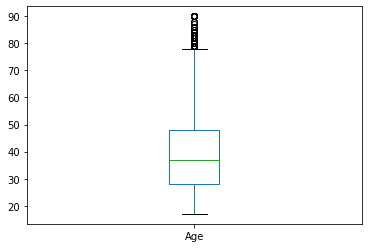

In [29]:
df["Age"].plot.box()

Here age have outside the viscous so we can find here outliers easily.

<AxesSubplot:>

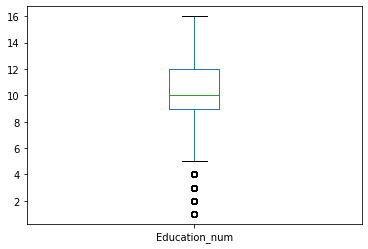

In [30]:
df["Education_num"].plot.box()

Here education_num have outside the viscous so we can find here outliers easily.

<AxesSubplot:>

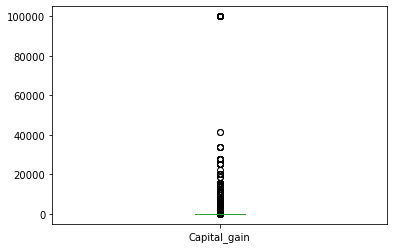

In [31]:
df["Capital_gain"].plot.box()

Here capital_gain have outside the viscous so we can find here outliers easily.

<AxesSubplot:>

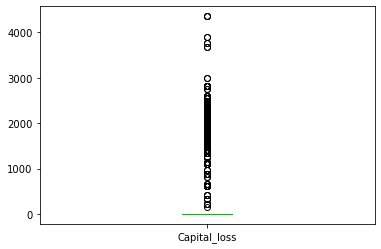

In [32]:
df["Capital_loss"].plot.box()

Here capital_loss have outside the viscous so we can find here outliers easily.

<AxesSubplot:>

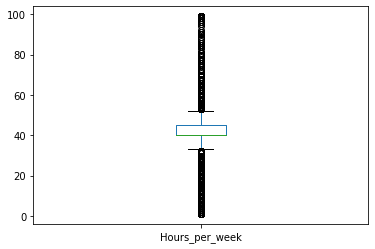

In [33]:
df["Hours_per_week"].plot.box()

Here hours_per_week have outside the viscous so we can find here outliers easily.

In [34]:
df.shape

(32560, 15)

# To Check Distribution of Skewness

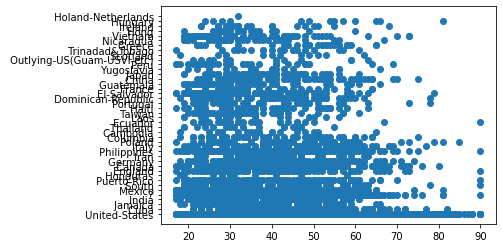

In [35]:
plt.scatter(df['Age'],df['Native_country'])

scattering the values of age and native_country

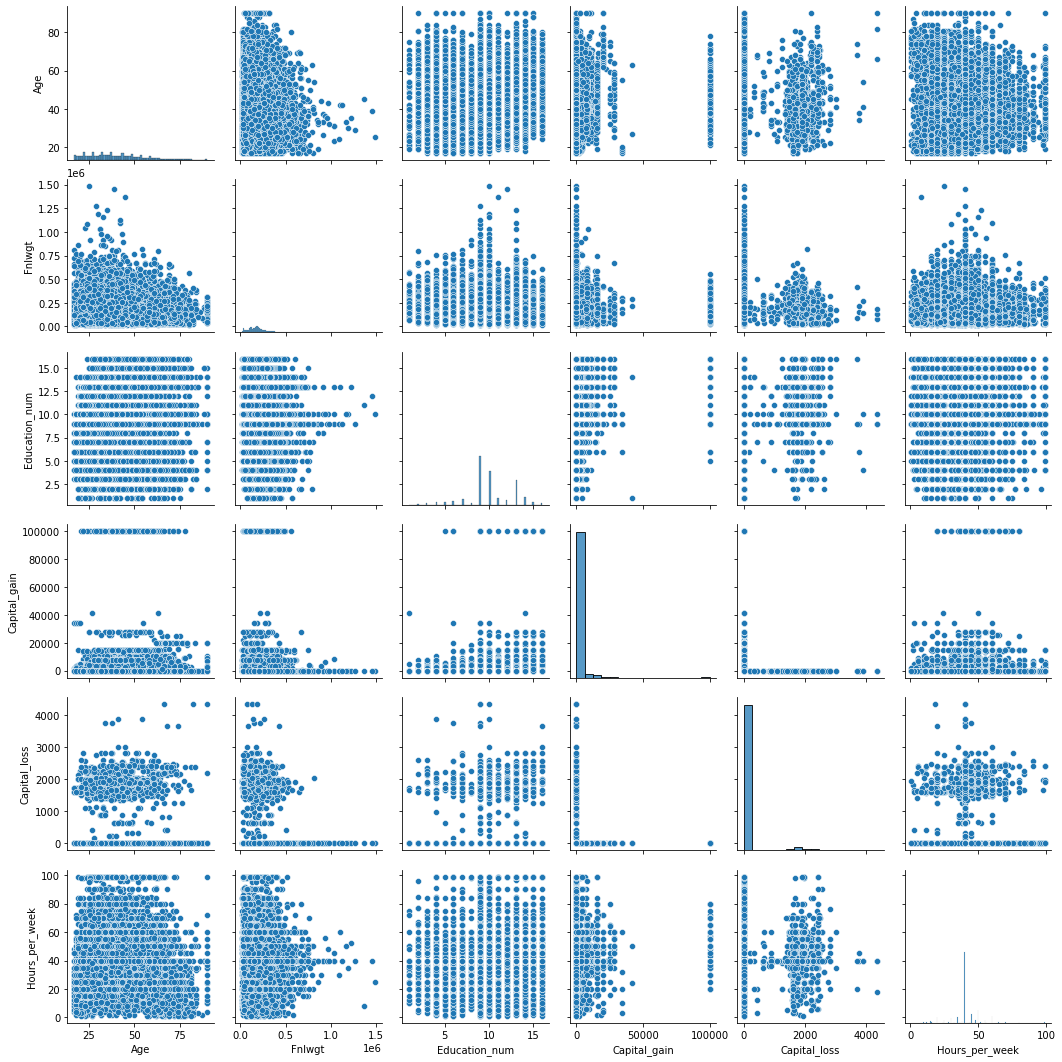

In [36]:
sns.pairplot(df)

Remove the missing values.

drop the nagativitycorrelated columns.

remove the outliers.

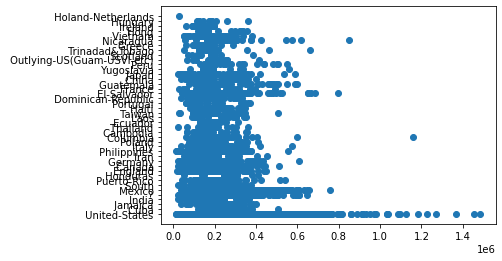

In [37]:
plt.scatter(df['Fnlwgt'],df['Native_country'])
plt.show()

Here scatter plots of Fnlwgt and Native_country

In [38]:
df.drop('Fnlwgt',axis=1,inplace=True)
df.head()

,Age,Workclass,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
0,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


In [39]:
df.shape

(32560, 14)

In [40]:
df.columns

Index(['Age', 'Workclass', 'Education', 'Education_num', 'Marital_status',
       'Occupation', 'Relationship', 'Race', 'Sex', 'Capital_gain',
       'Capital_loss', 'Hours_per_week', 'Native_country', 'Income'],
      dtype='object')

# Encoding Method

In [41]:
from sklearn.preprocessing import LabelEncoder
LE=LabelEncoder()
df['Age']=LE.fit_transform(df['Age'])

In [42]:
df.Age.unique()

array([33, 21, 36, 11, 20, 32, 35, 14, 25, 13,  6, 15, 23, 17,  8, 26, 37,
       18, 42, 39,  2, 22,  3, 28,  5, 31,  4,  7, 40, 27, 24, 12,  1, 30,
       29, 19, 62, 10, 50, 16, 59,  0, 38, 44, 53, 47, 54, 51, 49, 34, 41,
        9, 43, 72, 58, 48, 60, 45, 46, 63, 55, 57, 52, 56, 64, 61, 71, 65,
       66, 67, 68, 69, 70], dtype=int64)

In [43]:
df.head()

,Age,Workclass,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
0,33,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,21,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,36,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,11,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,20,Private,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


In [44]:
from sklearn.preprocessing import LabelEncoder
LE=LabelEncoder()
df['Marital_status']=LE.fit_transform(df['Marital_status'])

In [45]:
df.Marital_status.unique()

array([2, 0, 3, 4, 5, 1, 6])

In [46]:
df.head()

,Age,Workclass,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
0,33,Self-emp-not-inc,Bachelors,13,2,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,21,Private,HS-grad,9,0,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,36,Private,11th,7,2,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,11,Private,Bachelors,13,2,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,20,Private,Masters,14,2,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


In [47]:
from sklearn.preprocessing import LabelEncoder
LE=LabelEncoder()
df['Workclass']=LE.fit_transform(df['Workclass'])

In [48]:
df.Workclass.unique()

array([6, 4, 7, 1, 2, 0, 5, 8, 3])

In [49]:
df.head()

,Age,Workclass,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
0,33,6,Bachelors,13,2,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,21,4,HS-grad,9,0,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,36,4,11th,7,2,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,11,4,Bachelors,13,2,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,20,4,Masters,14,2,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


In [50]:
from sklearn.preprocessing import LabelEncoder
LE=LabelEncoder()
df['Education']=LE.fit_transform(df['Education'])

In [51]:
df.Education.unique()

array([ 9, 11,  1, 12,  6, 15,  7,  8,  5, 10, 14,  4,  0,  3, 13,  2])

In [52]:
df.head()

,Age,Workclass,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
0,33,6,9,13,2,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,21,4,11,9,0,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,36,4,1,7,2,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,11,4,9,13,2,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,20,4,12,14,2,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


In [53]:
from sklearn.preprocessing import LabelEncoder
LE=LabelEncoder()
df['Occupation']=LE.fit_transform(df['Occupation'])

In [54]:
df.Occupation.unique()

array([ 4,  6, 10,  8,  1, 12,  3, 14,  5,  7, 13,  0, 11,  2,  9])

In [55]:
df.head()

,Age,Workclass,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
0,33,6,9,13,2,4,Husband,White,Male,0,0,13,United-States,<=50K
1,21,4,11,9,0,6,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,36,4,1,7,2,6,Husband,Black,Male,0,0,40,United-States,<=50K
3,11,4,9,13,2,10,Wife,Black,Female,0,0,40,Cuba,<=50K
4,20,4,12,14,2,4,Wife,White,Female,0,0,40,United-States,<=50K


In [56]:
from sklearn.preprocessing import LabelEncoder
LE=LabelEncoder()
df['Relationship']=LE.fit_transform(df['Relationship'])

In [57]:
df.Relationship.unique()

array([0, 1, 5, 3, 4, 2])

In [58]:
df.head()

,Age,Workclass,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
0,33,6,9,13,2,4,0,White,Male,0,0,13,United-States,<=50K
1,21,4,11,9,0,6,1,White,Male,0,0,40,United-States,<=50K
2,36,4,1,7,2,6,0,Black,Male,0,0,40,United-States,<=50K
3,11,4,9,13,2,10,5,Black,Female,0,0,40,Cuba,<=50K
4,20,4,12,14,2,4,5,White,Female,0,0,40,United-States,<=50K


In [59]:
from sklearn.preprocessing import LabelEncoder
LE=LabelEncoder()
df['Race']=LE.fit_transform(df['Race'])

In [60]:
df.Race.unique()

array([4, 2, 1, 0, 3])

In [61]:
df.head()

,Age,Workclass,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
0,33,6,9,13,2,4,0,4,Male,0,0,13,United-States,<=50K
1,21,4,11,9,0,6,1,4,Male,0,0,40,United-States,<=50K
2,36,4,1,7,2,6,0,2,Male,0,0,40,United-States,<=50K
3,11,4,9,13,2,10,5,2,Female,0,0,40,Cuba,<=50K
4,20,4,12,14,2,4,5,4,Female,0,0,40,United-States,<=50K


In [62]:
from sklearn.preprocessing import LabelEncoder
LE=LabelEncoder()
df['Sex']=LE.fit_transform(df['Sex'])

In [63]:
df.Sex.unique()

array([1, 0])

In [64]:
df.head()

,Age,Workclass,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
0,33,6,9,13,2,4,0,4,1,0,0,13,United-States,<=50K
1,21,4,11,9,0,6,1,4,1,0,0,40,United-States,<=50K
2,36,4,1,7,2,6,0,2,1,0,0,40,United-States,<=50K
3,11,4,9,13,2,10,5,2,0,0,0,40,Cuba,<=50K
4,20,4,12,14,2,4,5,4,0,0,0,40,United-States,<=50K


In [65]:
from sklearn.preprocessing import LabelEncoder
LE=LabelEncoder()
df['Native_country']=LE.fit_transform(df['Native_country'])

In [66]:
df.Native_country.unique()

array([39,  5, 23, 19,  0, 26, 35, 33, 16,  9,  2, 11, 20, 30, 22, 31,  4,
        1, 37,  7, 25, 36, 14, 32,  6,  8, 10, 13,  3, 24, 41, 29, 28, 34,
       38, 12, 27, 40, 17, 21, 18, 15])

In [67]:
df.head()

,Age,Workclass,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
0,33,6,9,13,2,4,0,4,1,0,0,13,39,<=50K
1,21,4,11,9,0,6,1,4,1,0,0,40,39,<=50K
2,36,4,1,7,2,6,0,2,1,0,0,40,39,<=50K
3,11,4,9,13,2,10,5,2,0,0,0,40,5,<=50K
4,20,4,12,14,2,4,5,4,0,0,0,40,39,<=50K


In [68]:
from sklearn.preprocessing import LabelEncoder
LE=LabelEncoder()
df['Income']=LE.fit_transform(df['Income'])

In [69]:
df.Income.unique()

array([0, 1])

In [70]:
df.head()

,Age,Workclass,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
0,33,6,9,13,2,4,0,4,1,0,0,13,39,0
1,21,4,11,9,0,6,1,4,1,0,0,40,39,0
2,36,4,1,7,2,6,0,2,1,0,0,40,39,0
3,11,4,9,13,2,10,5,2,0,0,0,40,5,0
4,20,4,12,14,2,4,5,4,0,0,0,40,39,0


# Missing value Handling Method

In [71]:
df.isnull().sum()

Age               0
Workclass         0
Education         0
Education_num     0
Marital_status    0
Occupation        0
Relationship      0
Race              0
Sex               0
Capital_gain      0
Capital_loss      0
Hours_per_week    0
Native_country    0
Income            0
dtype: int64

Here all Datset contains sum value will be zero

In [72]:
df['Age']=df['Age'].fillna(df["Age"].mean())
df["Marital_status"]=df["Marital_status"].fillna(df["Marital_status"].median())

In [73]:
df.isnull().sum()

Age               0
Workclass         0
Education         0
Education_num     0
Marital_status    0
Occupation        0
Relationship      0
Race              0
Sex               0
Capital_gain      0
Capital_loss      0
Hours_per_week    0
Native_country    0
Income            0
dtype: int64

Here all values will be zeros

# Checking Skewness

In [74]:
df.skew()

Age                0.555583
Workclass         -0.752280
Education         -0.934063
Education_num     -0.311630
Marital_status    -0.013448
Occupation         0.114540
Relationship       0.786784
Race              -2.435332
Sex               -0.719244
Capital_gain      11.953690
Capital_loss       4.594549
Hours_per_week     0.227636
Native_country    -3.658235
Income             1.212383
dtype: float64

Dataset contains the skewness values

In [75]:
x_train=df.drop("Workclass",axis=1)
y_train=df["Workclass"]

In [77]:
df.columns

Index(['Age', 'Workclass', 'Education', 'Education_num', 'Marital_status',
       'Occupation', 'Relationship', 'Race', 'Sex', 'Capital_gain',
       'Capital_loss', 'Hours_per_week', 'Native_country', 'Income'],
      dtype='object')

Dataset contains the 14 columns

# Removing Outliers

In [78]:
from scipy.stats import zscore
z=np.abs(zscore(df))
z

array([[0.83749664, 1.46388339, 0.33544266, ..., 2.22212013, 0.29157343,
        0.5632099 ],
       [0.042559  , 0.09012148, 0.18131885, ..., 0.03542999, 0.29157343,
        0.5632099 ],
       [1.05751055, 0.09012148, 2.40248871, ..., 0.03542999, 0.29157343,
        0.5632099 ],
       ...,
       [1.42420039, 0.09012148, 0.18131885, ..., 0.03542999, 0.29157343,
        0.5632099 ],
       [1.21596651, 0.09012148, 0.18131885, ..., 1.65520046, 0.29157343,
        0.5632099 ],
       [0.98417258, 0.77700244, 0.18131885, ..., 0.03542999, 0.29157343,
        1.77553698]])

Here removing outliers of df

In [79]:
z_scores=zscore(df)

abs_z_scores=np.abs(z_scores)
filtered_entries=(abs_z_scores<3).all(axis=1)
new_df=df[filtered_entries]

new_df.head(5)

,Age,Workclass,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
0,33,6,9,13,2,4,0,4,1,0,0,13,39,0
1,21,4,11,9,0,6,1,4,1,0,0,40,39,0
2,36,4,1,7,2,6,0,2,1,0,0,40,39,0
4,20,4,12,14,2,4,5,4,0,0,0,40,39,0
5,32,4,6,5,3,8,1,2,0,0,0,16,23,0


In [80]:
df.shape

(32560, 14)

Dataset contains 32560 rows and 14 columns

# Feature Engineering

In [82]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaledX = scaler.fit_transform(df)

In [83]:
scaledX

array([[ 0.83749664,  1.46388339, -0.33544266, ..., -2.22212013,
         0.29157343, -0.5632099 ],
       [-0.042559  ,  0.09012148,  0.18131885, ..., -0.03542999,
         0.29157343, -0.5632099 ],
       [ 1.05751055,  0.09012148, -2.40248871, ..., -0.03542999,
         0.29157343, -0.5632099 ],
       ...,
       [ 1.42420039,  0.09012148,  0.18131885, ..., -0.03542999,
         0.29157343, -0.5632099 ],
       [-1.21596651,  0.09012148,  0.18131885, ..., -1.65520046,
         0.29157343, -0.5632099 ],
       [ 0.98417258,  0.77700244,  0.18131885, ..., -0.03542999,
         0.29157343,  1.77553698]])

Here Standardscaler values of scaledX

In [84]:
from sklearn.decomposition import PCA

testpca=PCA()
Y=testpca.fit(scaledX)

In [85]:
Y.explained_variance_ratio_

array([0.17137765, 0.10296028, 0.09037391, 0.08140058, 0.07434029,
       0.07312753, 0.0695387 , 0.06138706, 0.06046018, 0.05463309,
       0.04948042, 0.04651222, 0.03728711, 0.02712097])

In [87]:
var_cumu = np.cumsum(Y.explained_variance_ratio_)*100
var_cumu

array([ 17.1377645 ,  27.43379233,  36.47118349,  44.61124161,
        52.04527041,  59.3580239 ,  66.31189439,  72.45060004,
        78.4966181 ,  83.95992751,  88.90796947,  93.55919131,
        97.28790268, 100.        ])

In [88]:
k = np.argmax(var_cumu>99)
print("Number of components explaining 99% variance:",k)

Number of components explaining 99% variance: 13


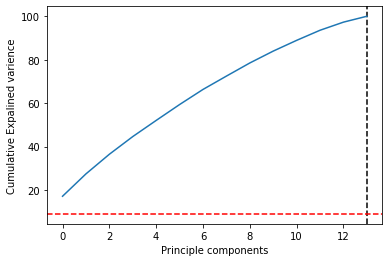

In [89]:
plt.ylabel('Cumulative Expalined varience')
plt.xlabel('Principle components')
plt.axvline(x=k, color="k",linestyle="--")
plt.axhline(y=9, color="r",linestyle="--")

plt.plot(var_cumu)
plt.show()

Here yplot is cumaltive explained varience and xplot is principle components

# Model Building

In [90]:
x_train=df.drop("Workclass",axis=1)
y_train=df["Workclass"]

In [91]:
x_train.head()

,Age,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
0,33,9,13,2,4,0,4,1,0,0,13,39,0
1,21,11,9,0,6,1,4,1,0,0,40,39,0
2,36,1,7,2,6,0,2,1,0,0,40,39,0
3,11,9,13,2,10,5,2,0,0,0,40,5,0
4,20,12,14,2,4,5,4,0,0,0,40,39,0


In [92]:
y_train.head()

0    6
1    4
2    4
3    4
4    4
Name: Workclass, dtype: int32

In [93]:
x_train.shape

(32560, 13)

Here x_train contains 32560 rows and 13 columns

In [94]:
y_train.shape

(32560,)

Here y_train contains 32560 rows and zero columns

In [95]:
df.head()

,Age,Workclass,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
0,33,6,9,13,2,4,0,4,1,0,0,13,39,0
1,21,4,11,9,0,6,1,4,1,0,0,40,39,0
2,36,4,1,7,2,6,0,2,1,0,0,40,39,0
3,11,4,9,13,2,10,5,2,0,0,0,40,5,0
4,20,4,12,14,2,4,5,4,0,0,0,40,39,0


# Classification Methods

In [96]:
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score

In [97]:
x=df.drop(["Marital_status"],axis=1)
y=df["Marital_status"]
x_train, x_test, y_train, y_test=train_test_split(x, y, random_state=50, test_size=0.2)

In [98]:
for i in range(200):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=i)
    from sklearn.tree import DecisionTreeClassifier
    lm=DecisionTreeClassifier()
    lm.fit(x_train,y_train)
    pred=lm.predict(x_test)
    accu=accuracy_score(y_test,pred)
    print(accu*100,"at random_state", i)

77.57096323871568 at random_state 0
78.39925546765937 at random_state 1
78.43648208469055 at random_state 2
78.39925546765937 at random_state 3
78.21312238250349 at random_state 4
77.78501628664495 at random_state 5
78.56677524429966 at random_state 6
78.11074918566774 at random_state 7
78.16658911121452 at random_state 8
78.13866914844112 at random_state 9
77.93392275476965 at random_state 10
78.52024197301071 at random_state 11
78.80874825500233 at random_state 12
78.06421591437878 at random_state 13
78.86458818054909 at random_state 14
78.10144253140996 at random_state 15
78.64122847836202 at random_state 16
78.06421591437878 at random_state 17
78.37133550488599 at random_state 18
78.32480223359703 at random_state 19
78.5109353187529 at random_state 20
78.5481619357841 at random_state 21
78.0362959516054 at random_state 22
78.75290832945556 at random_state 23
78.65053513261982 at random_state 24
78.0269892973476 at random_state 25
79.25546765937645 at random_state 26
78.613308515588

In [99]:
from sklearn.tree import DecisionTreeClassifier
maxAccu=0
maxRS=0
for i in range(1,200):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.30, random_state=0)
    mod = DecisionTreeClassifier()
    mod.fit(x_train,y_train)
    pred=mod.predict(x_test)
    acc=accuracy_score(y_test,pred)
    if acc>maxAccu:
        maxAccu=acc
        maxRS=1
print("Best accuracy is",maxAccu," on Random_state",maxRS)

Best accuracy is 0.7843980343980343  on Random_state 1


In [100]:
dt = DecisionTreeClassifier()
dt.fit(x_train,y_train)
y_pred_dt = dt.predict(x_test)
print("Decision Tree Classifier: \n\n",classification_report(y_test,y_pred_dt))
print("Test Accuracy:{}%".format(round(dt.score(x_test,y_test)*100,2)))

Decision Tree Classifier: 

               precision    recall  f1-score   support

           0       0.46      0.50      0.48      1353
           1       0.00      0.00      0.00        11
           2       0.98      0.99      0.98      4426
           3       0.05      0.05      0.05       114
           4       0.78      0.76      0.77      3235
           5       0.13      0.11      0.12       333
           6       0.36      0.34      0.35       296

    accuracy                           0.78      9768
   macro avg       0.39      0.39      0.39      9768
weighted avg       0.78      0.78      0.78      9768

Test Accuracy:78.19%


The Test Accuracy value of DecisionTreeClassifier is 78.01%

In [101]:
lr = LogisticRegression()
lr.fit(x_train,y_train)
y_pred_lr = lr.predict(x_test)
print("Logistic Regression Classifier: \n\n",classification_report(y_test,y_pred_lr))
print("Test Accuracy:{}%".format(round(lr.score(x_test,y_test)*100,2)))

Logistic Regression Classifier: 

               precision    recall  f1-score   support

           0       0.00      0.00      0.00      1353
           1       0.00      0.00      0.00        11
           2       0.50      0.99      0.66      4426
           3       0.00      0.00      0.00       114
           4       0.94      0.27      0.42      3235
           5       0.00      0.00      0.00       333
           6       0.00      0.00      0.00       296

    accuracy                           0.54      9768
   macro avg       0.21      0.18      0.16      9768
weighted avg       0.54      0.54      0.44      9768

Test Accuracy:54.05%


The Test Accuracy of logisticregression is 60.07%

In [102]:
from sklearn.neighbors import KNeighborsClassifier
best_Kvalue = 0
best_score = 0
for i in range(1,10):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_train,y_train)
    if knn.score(x_test,y_test) > best_score:
                                best_score = knn.score(x_train, y_train)
                                best_Kvalue = i
    print("Best KNN Value:{}".format(best_Kvalue )) 
    print("Test Accuarcy:{}".format(round(best_score*100,2)))

Best KNN Value:1
Test Accuarcy:98.86
Best KNN Value:1
Test Accuarcy:98.86
Best KNN Value:1
Test Accuarcy:98.86
Best KNN Value:1
Test Accuarcy:98.86
Best KNN Value:1
Test Accuarcy:98.86
Best KNN Value:1
Test Accuarcy:98.86
Best KNN Value:1
Test Accuarcy:98.86
Best KNN Value:1
Test Accuarcy:98.86
Best KNN Value:1
Test Accuarcy:98.86


In [103]:
KNN = KNeighborsClassifier()
KNN.fit(x_train,y_train)
y_pred_knn = knn.predict(x_test)
print(" KNN Classifier: \n\n",classification_report(y_test,y_pred_knn))
print("Test Accuracy:{}%".format(round(knn.score(x_test,y_test)*100,2)))

 KNN Classifier: 

               precision    recall  f1-score   support

           0       0.41      0.36      0.39      1353
           1       0.00      0.00      0.00        11
           2       0.72      0.86      0.79      4426
           3       0.00      0.00      0.00       114
           4       0.75      0.73      0.74      3235
           5       0.12      0.01      0.02       333
           6       0.38      0.14      0.20       296

    accuracy                           0.69      9768
   macro avg       0.34      0.30      0.30      9768
weighted avg       0.65      0.69      0.66      9768

Test Accuracy:68.81%


The Test Accuracy of KNN clssifier is 68.81%

In [104]:
svm = SVC()
svm.fit(x_train,y_train)
y_pred_svm = svm.predict(x_test)
print(" SVM Classifier: \n\n",classification_report(y_test,y_pred_svm))
print("Test Accuracy:{}%".format(round(svm.score(x_test,y_test)*100,2)))

 SVM Classifier: 

               precision    recall  f1-score   support

           0       0.33      0.00      0.01      1353
           1       0.00      0.00      0.00        11
           2       0.45      1.00      0.62      4426
           3       0.00      0.00      0.00       114
           4       0.67      0.00      0.00      3235
           5       0.00      0.00      0.00       333
           6       0.00      0.00      0.00       296

    accuracy                           0.45      9768
   macro avg       0.21      0.14      0.09      9768
weighted avg       0.47      0.45      0.28      9768

Test Accuracy:45.39%


The Test Accuracy of SVC is 45.39%

In [105]:
nb = GaussianNB()
nb.fit(x_train,y_train)
y_pred_nb = nb.predict(x_test)
print(" Navie byes Classifier: \n\n",classification_report(y_test,y_pred_nb))
print("Test Accuracy:{}%".format(round(nb.score(x_test,y_test)*100,2)))

 Navie byes Classifier: 

               precision    recall  f1-score   support

           0       0.33      0.03      0.06      1353
           1       0.00      0.82      0.00        11
           2       0.79      0.27      0.41      4426
           3       0.06      0.18      0.08       114
           4       0.64      0.26      0.37      3235
           5       0.12      0.09      0.10       333
           6       0.33      0.19      0.24       296

    accuracy                           0.23      9768
   macro avg       0.32      0.26      0.18      9768
weighted avg       0.63      0.23      0.33      9768

Test Accuracy:22.7%


The Test Accuracy of GaussianNB is 22.7%

In [106]:
rf = RandomForestClassifier()
rf.fit(x_train,y_train)
y_pred_rf = rf.predict(x_test)
print(" Random Forest Classifier: \n\n",classification_report(y_test,y_pred_rf))
print("Test Accuracy:{}%".format(round(rf.score(x_test,y_test)*100,2)))

 Random Forest Classifier: 

               precision    recall  f1-score   support

           0       0.51      0.58      0.54      1353
           1       0.00      0.00      0.00        11
           2       1.00      0.99      0.99      4426
           3       0.07      0.02      0.03       114
           4       0.79      0.85      0.82      3235
           5       0.16      0.04      0.06       333
           6       0.48      0.40      0.43       296

    accuracy                           0.82      9768
   macro avg       0.43      0.41      0.41      9768
weighted avg       0.81      0.82      0.81      9768

Test Accuracy:82.37%


The Test Accuracy of RandomForestClassifier is 82.37%

# Cross Value Correction

In [107]:
from sklearn.model_selection import cross_val_score

In [108]:
print(cross_val_score(dt,x,y,cv=5).mean())

0.7845515970515969


In [109]:
print(cross_val_score(lr,x,y,cv=5).mean())

0.596529484029484


In [111]:
print(cross_val_score(knn,x,y,cv=5).mean())

0.6950245700245701


In [112]:
print(cross_val_score(knn,x,y,cv=5).mean())

0.6950245700245701


In [113]:
print(cross_val_score(nb,x,y,cv=5).mean())

0.217997542997543


In [114]:
print(cross_val_score(rf,x,y,cv=5).mean())

0.828593366093366


# Hyperparameter Tunning

In [115]:
from sklearn.model_selection import GridSearchCV

In [116]:
param_grid = {
    'max_depth':[6,7,8],
    'max_features':['auto','sqrt'],
    'n_estimators':[200,300],
    'criterion' :['gini','entropy']
}

In [117]:
rf = RandomForestClassifier()

In [118]:
rf_cv = GridSearchCV(rf, param_grid, cv=5)

In [119]:
rf_cv.fit(x,y)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [6, 7, 8],
                         'max_features': ['auto', 'sqrt'],
                         'n_estimators': [200, 300]})

# AUC ROC curve

In [120]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

In [121]:
rf = RandomForestClassifier()
rf.fit(x_train,y_train)
y_pred_rf = rf.predict(x_test)
y_pred_prob = rf.predict_proba(x_test)[:,2]
y_pred_prob

array([1.  , 0.  , 0.04, ..., 1.  , 0.04, 0.99])

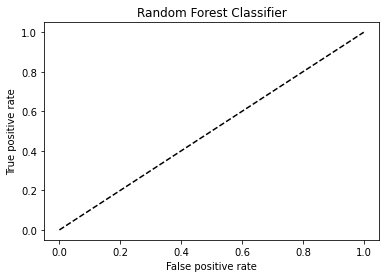

In [122]:
plt.plot([0,1],[0,1],'k--')
plt.plot(label='Random Forest Classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Random Forest Classifier')
plt.show()

Here the randomforestclassifier plot contains xlabel is false positive rate and y label is true positive rate.

# Evaluate the Final Model

In [123]:
Final_mod = RandomForestClassifier()
Final_mod.fit(x_train,y_train)
pred = Final_mod.predict(x_test)
acc=accuracy_score(y_test,pred)
print(acc*100)

82.47338247338247


# Saving the Model

In [124]:
import joblib
joblib.dump(Final_mod,"FinalModle.pkl")

['FinalModle.pkl']

# Prediction Method

In [125]:
rf = RandomForestClassifier()
rf.fit(x_train,y_train)
y_pred_rf = rf.predict(x_test)
preds = rf.predict(x_test)
print(preds[:36])
print(y_test[:36].values)

[2 0 4 4 2 2 0 4 0 6 4 4 2 4 0 0 4 2 2 6 0 2 2 2 0 2 4 4 4 2 2 4 2 4 4 4]
[2 4 5 4 2 2 5 4 0 6 0 4 2 4 0 0 4 2 2 0 5 2 2 2 0 2 4 4 4 2 2 4 2 4 4 4]


The train and test data is balanced most classification methods hit the 82% accuracy with the datset.